In [3]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt
import statsmodels
from statsmodels import tsa
#from statsmodels.tsa import arima_process
#from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa import seasonal

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
#from statsmodels.tsa import SARIMAX

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
#import wfdb
from scipy.io import loadmat  

#Local scripts
sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
from bnqdflow.effect_size_measures import MAE

In [4]:
def shifting_discontinuity_mean_function(x, d=0):
    """
    f(x) = sin((12+d) x) + (2/3)cos((25+d) x) where forall x>0, d=0
    :arg d: order of discontinuity in frequency
    """
    return (x<=0)*np.sin(12*x) + (x>0)*np.sin((12+d)*x)+ (x<=0)*0.66*np.cos(25*x) + (x>0)*0.66*np.cos((25+d)*x)
def triple_trigonometry(x, d=0):
    """
    f(x) = sin(5x) + cos(17x) + sin(28x)
    :arg d: order of discontinuity
    """
    return (np.cos(5*x) +np.cos(17*x) + np.cos(28*x))*(x<=0) + (np.cos((5+d)*x) +np.cos((17+d)*x) + np.cos((28+d)*x))*(x>0)

In [5]:
def grid_search(y, max_ar, max_ma):

    BIC = np.zeros((max_ar, max_ma))
       
    for ar in range(max_ar):
        for ma in range(max_ma):
            
            mod = ARIMA(y, order=(ar, 0, ma), trend='n')           
            res = mod.fit() 
            BIC[ar,ma] = -0.5*res.bic

    (ar, ma) = np.unravel_index(np.argmax(BIC, axis=None), BIC.shape)
    del BIC
    return ar, ma

In [26]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
np.random.seed(2020)


# Create synthetic data
N           = 200
sigma       = .2
b           = 0.
x           = np.linspace(-1.25, 1.25, N)
fs          = N/2.5
x1, x2      = x[x<=b], x[x>b]

xlim        = [-1.5,1.5]
xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)

padding     = 0.1
n_seeds     = 20

# Iterate over discontinuity sizes
discontinuity_sizes   = np.arange(0, 9, step=1) 
#discontinuity_sizes   = np.arange(4, 5, step=1)

d = 0
discontinuity_funcs   = [('Shifting',shifting_discontinuity_mean_function, 2,[[12, 25],[(12+d), (25+d)]],  (-1.7,2.) )]#,
                          #('triple trigonometry', triple_trigonometry, 3, [[5, 17 , 28 ], [(5+d), (17 + d) , (28 + d)]], (-4.7,5.2)  )]
bayes_factors  = np.zeros((discontinuity_sizes.shape[0], n_seeds))
effect_sizes, true_effect =  [np.zeros((discontinuity_sizes.shape[0], n_seeds, int(N/2))) for i in range(2)]
parameter_values = np.zeros((discontinuity_sizes.shape[0], n_seeds, 3, 2))
plot_regression=True

for n, (name, func, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
    for i, d in enumerate(discontinuity_sizes):                
        print(f'discontinuity: {d}')
        true_freqs[1] = true_freqs[0] + d
        mean_log_BF = 0
        for s in range(n_seeds): # repeated trials with varying gaussian noise
            ## Generate data with noise
            f = func(x,d)
            y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
            y1, y2            = y[x <= b], y[x > b]

            #fig, ax = plt.subplots(1,3,figsize=(10*3,8))
            max_ar, max_ma = 4, 4

            # Continuous         
            time_series_pd= pd.Series(y.flatten())
            ar, ma = grid_search(y, max_ar, max_ma)
            parameter_values[i,s,0] = [ar, ma]
            #print(ar, ma)
            mod = ARIMA(y, order=(ar, 0, ma), trend='n')           
            res = mod.fit() 

            #print(res.summary())
            BIC_m0 = -0.5*res.bic#res.loglikelihood     
            x_100 = np.linspace(-1.25,1.25, 100)
            true_func = func(x_100, d)
#             ax[0].scatter(np.arange(0,100),y, color='black', marker='x', label='data')
#             ax[0].plot(np.arange(0,100),true_func, color='black', marker='x')

#             fig = plot_predict(res, start=0, end=100, ax=ax[0])
# #             print(f'BIC m0: {BIC_m0}')
#             ax[0].set_title('Continuous model')
#             legend = ax[0].legend(loc='upper left')
            
            # Control
            time_series_pd= pd.Series(y1.flatten())
            ar, ma = grid_search(y1, max_ar, max_ma)
            parameter_values[i,s,1] = [ar, ma]

            #print(ar, ma)

            mod = ARIMA(y1, order=(ar, 0, ma), trend='n')           
            res = mod.fit() 
            
            BIC_m1 = -0.5*res.bic
#             print(BIC_m1)
#             ax[1].set_title('Control model')
#             ax[1].scatter(np.arange(0,100),y, color='black', marker='x', label='data')
#             ax[1].plot(np.arange(0,100),true_func, color='black', marker='x')

#             fig = plot_predict(res, start=0, end=100, ax=ax[1])
#             legend = ax[1].legend(loc='upper left')
            
            # Intervention
            time_series_pd= pd.Series(y2.flatten())
            ar, ma = grid_search(y2, max_ar, max_ma)
            parameter_values[i,s,2] = [ar, ma]

            #print(ar, ma)
            mod = ARIMA(y2, order=(ar, 0, ma), trend='n')           
            res = mod.fit() 
            BIC_m1 += (-0.5*res.bic)
            
            print(f'd={d}, s={s} log BF_10: {BIC_m1-BIC_m0}')

            f_int = res.fittedvalues
            #plt.plot(x1, res.fittedvalues)
            forecast_control = res.forecast(steps=100)
#             plt.plot(x2, f_int)
#             plt.plot(x2, forecast_control)
#             plt.show()
            effect_sizes[i,s] = np.absolute(np.array(f_int) - np.array(forecast_control))
#             ax[2].set_title('Intervention model')
#             ax[2].scatter(np.arange(0,50),y[50:], color='black', marker='x', label='data')
#             ax[2].plot(np.arange(0,50),true_func[50:], color='black', marker='x')

#             fig = plot_predict(res, start=0, end=50, ax=ax[2])
#             legend = ax[2].legend(loc='upper left')
#             plt.show()
            
            log_BF = BIC_m1-BIC_m0 # note: check if this is correct. For the BIC in the package lower is better, whereas for BIC in SDD higher is better
            bayes_factors[i,s] = log_BF
            
            #print(f'log BF: {BIC_m1/BIC_m0}')
np.save('bayes_factors_ARIMA', bayes_factors)
np.save('effect_sizes_ARIMA', effect_sizes)
print('bayes factors: ')
print(bayes_factors)

discontinuity: 0
d=0, s=0 log BF_10: -10.704620186403538
d=0, s=1 log BF_10: -9.88696895841963
d=0, s=2 log BF_10: -11.611604727775457
d=0, s=3 log BF_10: -13.141864074778777
d=0, s=4 log BF_10: -12.44858080985982
d=0, s=5 log BF_10: -9.463312785019482
d=0, s=6 log BF_10: -4.955509909017586
d=0, s=7 log BF_10: -9.992175597949341
d=0, s=8 log BF_10: -12.122558126826867
d=0, s=9 log BF_10: -10.165369162302042
d=0, s=10 log BF_10: -10.95085088401376
d=0, s=11 log BF_10: -12.899718433460023
d=0, s=12 log BF_10: -8.965405484125355
d=0, s=13 log BF_10: -9.48035819241624
d=0, s=14 log BF_10: -8.783657216720052
d=0, s=15 log BF_10: -8.28947579641784
d=0, s=16 log BF_10: -10.542461255829597
d=0, s=17 log BF_10: -9.849455344572533
d=0, s=18 log BF_10: -9.10826028445885
d=0, s=19 log BF_10: -13.968721178890668
discontinuity: 1
d=1, s=0 log BF_10: -9.823904421485153
d=1, s=1 log BF_10: -9.549610379362
d=1, s=2 log BF_10: -9.384572702746233
d=1, s=3 log BF_10: -7.0055096832259025
d=1, s=4 log BF_10

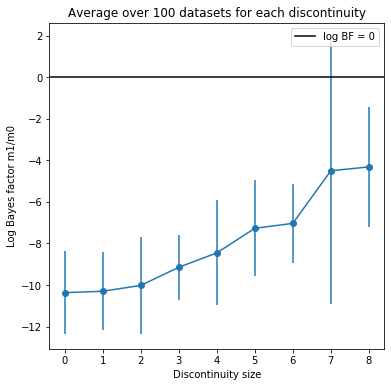

In [27]:
fig = plt.figure(figsize=(6,6))

plt.errorbar(discontinuity_sizes, np.mean(bayes_factors, axis=1), yerr= np.std(bayes_factors, axis=1), marker='o')
plt.axhline(0, color='black', label='log BF = 0')
plt.title('Average over 100 datasets for each discontinuity')
plt.xlabel('Discontinuity size')
plt.ylabel('Log Bayes factor m1/m0')
plt.legend(loc='best')
plt.show()

In [ ]:
# from statsmodels.tsa.ar_model import AutoReg, ar_select_order
# # AR model 1
# np.random.seed(1)

# # Create synthetic data
# N           = 200
# sigma       = .3
# b           = 0.
# x           = np.linspace(-1.25, 1.25, N)
# fs          = N/2.5
# x1, x2      = x[x<=b], x[x>b]

# xlim        = [-1.5,1.5]
# xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)

# padding     = 0.1
# n_seeds     = 1

# # Iterate over discontinuity sizes
# discontinuity_sizes   = np.arange(0, 9, step=1) # double cosine

# d = 0
# discontinuity_funcs   = [('Shifting',shifting_discontinuity_mean_function, 2,[[12, 25],[(12+d), (25+d)]],  (-1.7,2.) )]#,
#                           #('triple trigonometry', triple_trigonometry, 3, [[5, 17 , 28 ], [(5+d), (17 + d) , (28 + d)]], (-4.7,5.2)  )]
# bayes_factors, effect_sizes = [np.zeros((len(discontinuity_funcs), discontinuity_sizes.shape[0],n_seeds)) for i in range(2)]

# plot_regression=True

# for n, (name, func, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
#     for i, d in enumerate(discontinuity_sizes):                
#         print(f'discontinuity: {d}')
#         true_freqs[1] = true_freqs[0] + d
        
#         for s in range(n_seeds): # repeated trials with varying gaussian noise
#             ## Generate data with noise
#             f = func(x,d)
#             y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
#             y1, y2            = y[x <= b], y[x > b]

#             data = [(x,y), (x1,y1), (x2,y2)]
            
# #             # Plot data
# #             plt.show()
# #             plt.scatter(x1,y1, color='black', marker='x')
# #             plt.plot(xx, func(xx, d))
# #             plt.show()
            
#             period = 20
    
#             # Continuous         
            
#             time_series_pd= pd.Series(y.flatten())
#             dp = DeterministicProcess(time_series_pd, constant=True, period=period, fourier=2)
#             mod = AutoReg(time_series_pd,2 , trend="n",seasonal=False, deterministic=dp)
#             res = mod.fit() 
#             BIC_m0 = res.bic
#             fig = res.plot_predict(0, 100)
            
#             # Control
#             time_series_pd= pd.Series(y1.flatten())
#             dp = DeterministicProcess(time_series_pd, constant=True, period=period, fourier=2)
#             mod = AutoReg(time_series_pd,2 , trend="n",seasonal=False, deterministic=dp)
#             res = mod.fit() 
#             BIC_m1 = res.bic
#             fig = res.plot_predict(0, 100)
            
#             # Intervention
#             time_series_pd= pd.Series(y2.flatten())
#             dp = DeterministicProcess(time_series_pd, constant=True, period=period, fourier=2)
#             mod = AutoReg(time_series_pd,2 , trend="n",seasonal=False, deterministic=dp)
#             res = mod.fit() 
#             BIC_m1 += res.bic
#             fig = res.plot_predict(0, 50)
#             plt.show()
            
#             print(f'log BF: {BIC_m1/BIC_m0}')
        